## Lead scoring case study

## Step1: Importing libraries and Dataset

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
leads = pd.read_csv('Leads.csv')

## Step2: Data cleaning

In [3]:
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [4]:
leads.shape

(9240, 37)

In [5]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [6]:
# Checking for missing value count
leads.isnull().sum().sort_values(ascending=False)

Lead Quality                                     4767
Asymmetrique Activity Index                      4218
Asymmetrique Profile Score                       4218
Asymmetrique Activity Score                      4218
Asymmetrique Profile Index                       4218
Tags                                             3353
Lead Profile                                     2709
What matters most to you in choosing a course    2709
What is your current occupation                  2690
Country                                          2461
How did you hear about X Education               2207
Specialization                                   1438
City                                             1420
Page Views Per Visit                              137
TotalVisits                                       137
Last Activity                                     103
Lead Source                                        36
Receive More Updates About Our Courses              0
I agree to pay the amount th

 Dropping columns with more than 40% missing values

In [7]:
len(leads)

9240

In [8]:
x = len(leads)*.4
x

3696.0

In [9]:
leads.columns[leads.isna().sum() < x]

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'How did you hear about X Education',
       'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'Lead Profile', 'City', 'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [10]:
len(leads.columns[leads.isna().sum() < x])

32

In [11]:
leads = leads[ leads.columns[leads.isna().sum() < x] ]
leads.shape

(9240, 32)

In [12]:
# Dropping Sales team generated columns as these are not required for model building

leads = leads.drop(['Last Activity','Last Notable Activity','Lead Profile','Tags'], axis=1)
leads.shape

(9240, 28)

## Handling missing values

In [13]:
leads.isna().sum().sort_values(ascending=False)

What matters most to you in choosing a course    2709
What is your current occupation                  2690
Country                                          2461
How did you hear about X Education               2207
Specialization                                   1438
City                                             1420
TotalVisits                                       137
Page Views Per Visit                              137
Lead Source                                        36
Digital Advertisement                               0
Through Recommendations                             0
Receive More Updates About Our Courses              0
X Education Forums                                  0
Update me on Supply Chain Content                   0
Get updates on DM Content                           0
I agree to pay the amount through cheque            0
Newspaper                                           0
Prospect ID                                         0
Newspaper Article           

Imputing the missing values

In [14]:
leads['What matters most to you in choosing a course'].value_counts()

Better Career Prospects      6528
Flexibility & Convenience       2
Other                           1
Name: What matters most to you in choosing a course, dtype: int64

In [15]:
# As this is an imbalanced dataset, this column can be dropped
leads = leads.drop(['What matters most to you in choosing a course'], axis=1)
leads.shape

(9240, 27)

In [16]:
leads['What is your current occupation'].value_counts()

Unemployed              5600
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

In [17]:
# Filling nan values with mode value
leads['What is your current occupation'] = leads['What is your current occupation'].fillna('Unemployed')

In [18]:
leads['What is your current occupation'].value_counts()

Unemployed              8290
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

In [19]:
leads['Country'].value_counts()

India                   6492
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
France                     6
Oman                       6
unknown                    5
Canada                     4
South Africa               4
Nigeria                    4
Kuwait                     4
Germany                    4
Sweden                     3
Italy                      2
Asia/Pacific Region        2
Belgium                    2
Ghana                      2
China                      2
Philippines                2
Uganda                     2
Netherlands                2
Bangladesh                 2
Sri Lanka                  1
Kenya                      1
Russia                     1
Denmark                    1
Switzerland                1
Liberia                    1
Indonesia     

In [20]:
# Filling nan values with mode value
leads['Country'] = leads['Country'].fillna('India')

In [21]:
leads['Country'].value_counts()

India                   8953
United States             69
United Arab Emirates      53
Singapore                 24
Saudi Arabia              21
United Kingdom            15
Australia                 13
Qatar                     10
Hong Kong                  7
Bahrain                    7
France                     6
Oman                       6
unknown                    5
Canada                     4
South Africa               4
Nigeria                    4
Kuwait                     4
Germany                    4
Sweden                     3
Italy                      2
Asia/Pacific Region        2
Belgium                    2
Ghana                      2
China                      2
Philippines                2
Uganda                     2
Netherlands                2
Bangladesh                 2
Sri Lanka                  1
Kenya                      1
Russia                     1
Denmark                    1
Switzerland                1
Liberia                    1
Indonesia     

In [22]:
# As this is an imbalanced dataset, this column can be dropped
leads = leads.drop(['Country'], axis=1)
leads.shape

(9240, 26)

In [23]:
leads['How did you hear about X Education'].value_counts()

Select                   5043
Online Search             808
Word Of Mouth             348
Student of SomeSchool     310
Other                     186
Multiple Sources          152
Advertisements             70
Social Media               67
Email                      26
SMS                        23
Name: How did you hear about X Education, dtype: int64

In [24]:
# 'select' can be considered as nan value because values were not entered during data collection. As these select and nan count are more than 40%, this column can be deleted
leads = leads.drop(['How did you hear about X Education'], axis=1)
leads.shape

(9240, 25)

In [25]:
leads['Specialization'].value_counts()

Select                               1942
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Travel and Tourism                    203
Media and Advertising                 203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64

In [26]:
# Deleting this column as select and nan count is more
leads = leads.drop(['Specialization'], axis=1)
leads.shape

(9240, 24)

In [27]:
leads['City'].value_counts()

Mumbai                         3222
Select                         2249
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

In [28]:
# Deleting this column as select and nan count is more
leads = leads.drop(['City'], axis=1)
leads.shape

(9240, 23)

In [29]:
leads['TotalVisits'].value_counts()

0.0      2189
2.0      1680
3.0      1306
4.0      1120
5.0       783
6.0       466
1.0       395
7.0       309
8.0       224
9.0       164
10.0      114
11.0       86
13.0       48
12.0       45
14.0       36
16.0       21
15.0       18
17.0       16
18.0       15
20.0       12
19.0        9
21.0        6
23.0        6
25.0        5
24.0        5
27.0        5
22.0        3
28.0        2
29.0        2
26.0        2
115.0       1
41.0        1
55.0        1
251.0       1
141.0       1
32.0        1
42.0        1
74.0        1
43.0        1
30.0        1
54.0        1
Name: TotalVisits, dtype: int64

In [30]:
leads['TotalVisits'].describe()

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64

In [31]:
# FIlling nan values with median value
leads['TotalVisits'] = leads['TotalVisits'].fillna(leads['TotalVisits'].median())

In [32]:
leads['TotalVisits'].value_counts()

0.0      2189
2.0      1680
3.0      1443
4.0      1120
5.0       783
6.0       466
1.0       395
7.0       309
8.0       224
9.0       164
10.0      114
11.0       86
13.0       48
12.0       45
14.0       36
16.0       21
15.0       18
17.0       16
18.0       15
20.0       12
19.0        9
21.0        6
23.0        6
25.0        5
24.0        5
27.0        5
22.0        3
28.0        2
29.0        2
26.0        2
115.0       1
41.0        1
55.0        1
251.0       1
141.0       1
32.0        1
42.0        1
74.0        1
43.0        1
30.0        1
54.0        1
Name: TotalVisits, dtype: int64

In [33]:
leads = leads.dropna()

In [34]:
leads.shape

(9074, 23)

In [35]:
leads.isna().sum()

Prospect ID                                 0
Lead Number                                 0
Lead Origin                                 0
Lead Source                                 0
Do Not Email                                0
Do Not Call                                 0
Converted                                   0
TotalVisits                                 0
Total Time Spent on Website                 0
Page Views Per Visit                        0
What is your current occupation             0
Search                                      0
Magazine                                    0
Newspaper Article                           0
X Education Forums                          0
Newspaper                                   0
Digital Advertisement                       0
Through Recommendations                     0
Receive More Updates About Our Courses      0
Update me on Supply Chain Content           0
Get updates on DM Content                   0
I agree to pay the amount through 

In [36]:
# percentage of rows retained
per = 9074*100/9240
per

98.2034632034632

## Step 3: Data Preparation

## EDA

In [37]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9074 entries, 0 to 9239
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Prospect ID                               9074 non-null   object 
 1   Lead Number                               9074 non-null   int64  
 2   Lead Origin                               9074 non-null   object 
 3   Lead Source                               9074 non-null   object 
 4   Do Not Email                              9074 non-null   object 
 5   Do Not Call                               9074 non-null   object 
 6   Converted                                 9074 non-null   int64  
 7   TotalVisits                               9074 non-null   float64
 8   Total Time Spent on Website               9074 non-null   int64  
 9   Page Views Per Visit                      9074 non-null   float64
 10  What is your current occupation     

In [38]:
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,I agree to pay the amount through cheque,A free copy of Mastering The Interview
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,No,No,No,No,No,No,No,No,No
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,No,No,No,No,No,No,No,No,No
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,No,No,No,No,No,No,No,No,Yes
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,No,No,No,No,No,No,No,No,No
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,No,No,No,No,No,No,No,No,No


In [39]:
leads['Do Not Email'].value_counts()

No     8358
Yes     716
Name: Do Not Email, dtype: int64

In [40]:
# This column has imbalanced data and hence can be deleted
leads = leads.drop(['Do Not Email'], axis=1)

In [41]:
leads['Do Not Call'].value_counts()

No     9072
Yes       2
Name: Do Not Call, dtype: int64

In [42]:
# This column has imbalanced data and hence can be deleted
leads = leads.drop(['Do Not Call'], axis=1)

In [43]:
leads.Converted.value_counts()

0    5639
1    3435
Name: Converted, dtype: int64

In [44]:
leads['Search'].value_counts()

No     9060
Yes      14
Name: Search, dtype: int64

In [45]:
# This column has imbalanced data and hence can be deleted
leads = leads.drop(['Search'], axis=1)

In [46]:
leads['Magazine'].value_counts()

No    9074
Name: Magazine, dtype: int64

In [47]:
# It has only one category and so, it can be dropped
leads = leads.drop(['Magazine'], axis=1)

In [48]:
leads['Newspaper Article'].value_counts()

No     9072
Yes       2
Name: Newspaper Article, dtype: int64

In [49]:
# This column has an imbalanced data and hence can be deleted
leads = leads.drop(['Newspaper Article'], axis=1)

In [50]:
leads['X Education Forums'].value_counts()

No     9073
Yes       1
Name: X Education Forums, dtype: int64

In [51]:
# This column has an imbalanced data and hence can be deleted
leads = leads.drop(['X Education Forums'], axis=1)

In [52]:
leads['Newspaper'].value_counts()

No     9073
Yes       1
Name: Newspaper, dtype: int64

In [53]:
# This column has imbalanced data and hence can be deleted
leads = leads.drop(['Newspaper'], axis=1)

In [54]:
leads['Digital Advertisement'].value_counts()

No     9070
Yes       4
Name: Digital Advertisement, dtype: int64

In [55]:
# This column has imbalanced data and hence can be deleted
leads = leads.drop(['Digital Advertisement'], axis=1)

In [56]:
leads['Through Recommendations'].value_counts()

No     9067
Yes       7
Name: Through Recommendations, dtype: int64

In [57]:
# This column has imbalanced data and hence can be deleted
leads = leads.drop(['Through Recommendations'], axis=1)

In [58]:
leads['Receive More Updates About Our Courses'].value_counts()

No    9074
Name: Receive More Updates About Our Courses, dtype: int64

In [59]:
# It has only one category and so, it can be dropped
leads = leads.drop(['Receive More Updates About Our Courses'], axis=1)

In [60]:
leads['Update me on Supply Chain Content'].value_counts()

No    9074
Name: Update me on Supply Chain Content, dtype: int64

In [61]:
# It has only one category and so, it can be dropped
leads = leads.drop(['Update me on Supply Chain Content'], axis=1)

In [62]:
leads['Get updates on DM Content'].value_counts()

No    9074
Name: Get updates on DM Content, dtype: int64

In [63]:
# It has only one category and so, it can be dropped
leads = leads.drop(['Get updates on DM Content'], axis=1)

In [64]:
leads['I agree to pay the amount through cheque'].value_counts()

No    9074
Name: I agree to pay the amount through cheque, dtype: int64

In [65]:
# It has only one category and so, it can be dropped
leads = leads.drop(['I agree to pay the amount through cheque'], axis=1)

In [66]:
leads['A free copy of Mastering The Interview'].value_counts()

No     6186
Yes    2888
Name: A free copy of Mastering The Interview, dtype: int64

In [67]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9074 entries, 0 to 9239
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Prospect ID                             9074 non-null   object 
 1   Lead Number                             9074 non-null   int64  
 2   Lead Origin                             9074 non-null   object 
 3   Lead Source                             9074 non-null   object 
 4   Converted                               9074 non-null   int64  
 5   TotalVisits                             9074 non-null   float64
 6   Total Time Spent on Website             9074 non-null   int64  
 7   Page Views Per Visit                    9074 non-null   float64
 8   What is your current occupation         9074 non-null   object 
 9   A free copy of Mastering The Interview  9074 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 779.8+ KB


In [68]:
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,What is your current occupation,A free copy of Mastering The Interview
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,0,0.0,0,0.0,Unemployed,No
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,0,5.0,674,2.5,Unemployed,No
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,1,2.0,1532,2.0,Student,Yes
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,0,1.0,305,1.0,Unemployed,No
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,1,2.0,1428,1.0,Unemployed,No


## Visualising Numerical variables

In [69]:
leads.describe()

,Lead Number,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9074.000000,9074.000000,9074.000000,9074.000000,9074.000000
mean,617032.619352,0.378554,3.456028,482.887481,2.370151
std,23348.029512,0.485053,4.858802,545.256560,2.160871
min,579533.000000,0.000000,0.000000,0.000000,0.000000
25%,596406.000000,0.000000,1.000000,11.000000,1.000000
50%,615278.500000,0.000000,3.000000,246.000000,2.000000
75%,637176.500000,1.000000,5.000000,922.750000,3.200000
max,660737.000000,1.000000,251.000000,2272.000000,55.000000


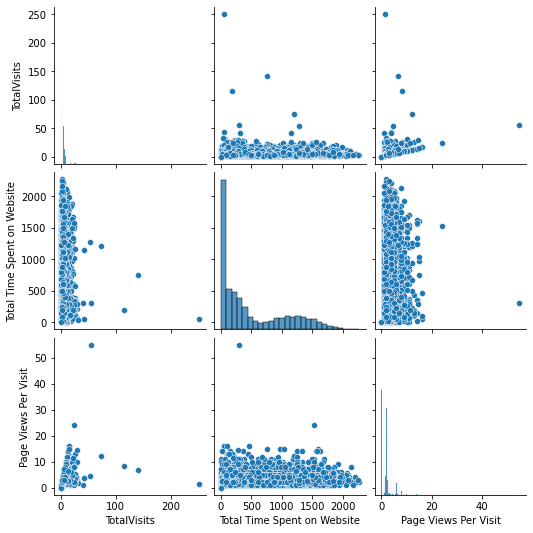

In [70]:
num_vars = ['TotalVisits','Total Time Spent on Website','Page Views Per Visit']
sns.pairplot(leads[num_vars])
plt.show()

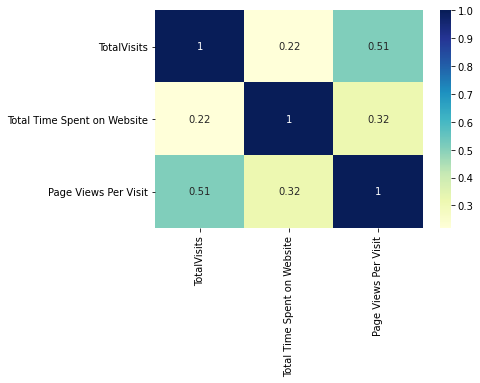

In [71]:
# COrrelation for numerical variables

sns.heatmap(leads[num_vars].corr(), annot = True, cmap="YlGnBu")
plt.show()

Observations: Total visits and Page views per visit have psitive correlation. There is no significant correlation among other variables
    

## Visulaizing Categorical variables

In [72]:
# Varaible 'Converted' is the target variable

target_0 = leads.loc[leads['Converted'] == 0]
target_1 = leads.loc[leads['Converted'] == 1]

In [73]:
cat_vars = ['Lead Origin','Lead Source','What is your current occupation','A free copy of Mastering The Interview']

In [74]:
def plotting(train, target0, target1, column):
    
    train = train
    target_0 = target0
    target_1 = target1
    col = column
    
    fig = plt.figure(figsize=(12,5))
    
    ax1 = plt.subplot(121)
    train[col].value_counts().plot.pie(autopct = "%1.0f%%", ax=ax1)
    plt.title('Plotting data for the column: '+ column)
    
    ax2 = plt.subplot(122)
    sns.countplot(x= column, hue = 'Converted', data = train, ax = ax2)
    plt.xticks(rotation=90)
    plt.title('Plotting data for target in terms of total count')
    
    fig.tight_layout() 

    plt.show()

Pltting  Lead Origin


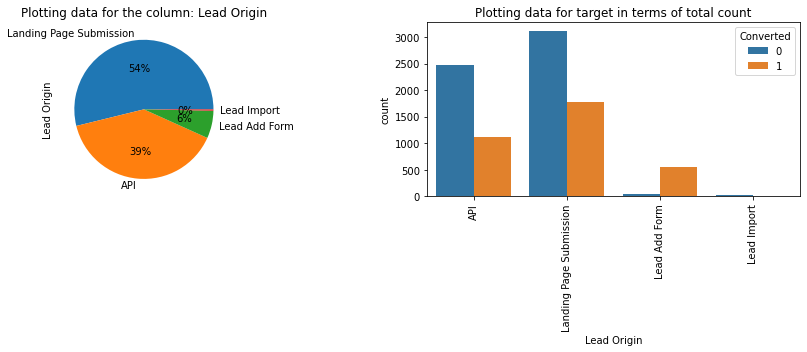

Pltting  Lead Source


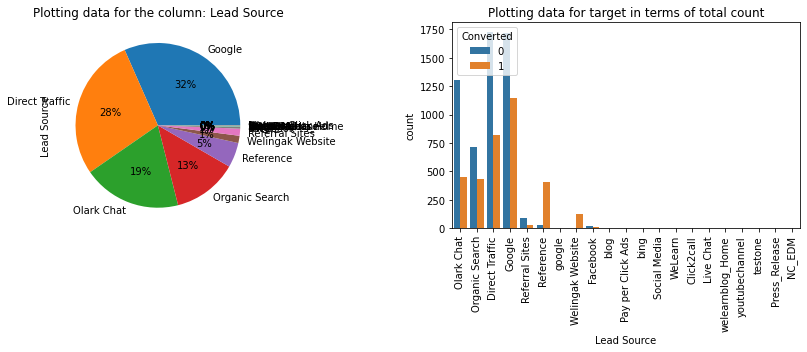

Pltting  What is your current occupation


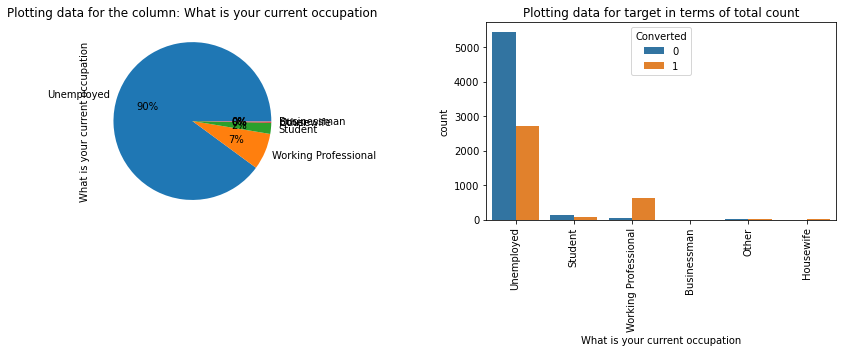

Pltting  A free copy of Mastering The Interview


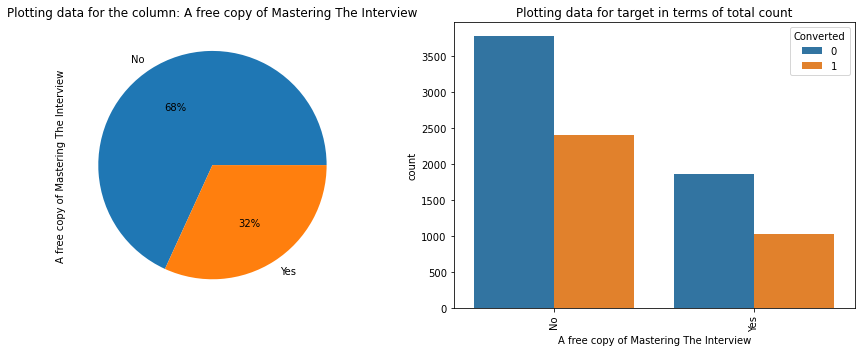

In [75]:
for column in cat_vars:
    print("Pltting ",column)
    plotting(leads, target_0, target_1, column)
    print("=======================================================")

Observations:
1. Lead Origin variable: Most leads have identified from Landing Page submission but Lead add forum has more percentage of converting Leads to Successful leads.
2. Lead Source variable: Most leads have sourced from Google and Direct Traffic. Google has more potential to convert into successful leads
3. Current Occupation variable: Mostly unemployed have visited but Working professionals are mostly converting to successful leads

## Creating Dummies for Categorical columns

In [76]:
leads['Lead Origin'].value_counts()

Landing Page Submission    4885
API                        3578
Lead Add Form               581
Lead Import                  30
Name: Lead Origin, dtype: int64

In [77]:
# Creating dummy variables for the variable 'Lead Origin'
lo = pd.get_dummies(leads['Lead Origin'], prefix='Lead Origin')
# Dropping MultipleLines_No phone service column
lo1 = lo.drop(['Lead Origin_Lead Import'], 1)
#Adding the results to the master dataframe
leads = pd.concat([leads,lo1], axis=1)

In [78]:
leads['Lead Source'].value_counts()

Google               2868
Direct Traffic       2543
Olark Chat           1753
Organic Search       1154
Reference             443
Welingak Website      129
Referral Sites        125
Facebook               31
bing                    6
google                  5
Click2call              4
Social Media            2
Live Chat               2
Press_Release           2
youtubechannel          1
blog                    1
NC_EDM                  1
welearnblog_Home        1
WeLearn                 1
testone                 1
Pay per Click Ads       1
Name: Lead Source, dtype: int64

In [79]:
#Assigning all insignificant categories to Others 
leads['Lead Source'] = leads['Lead Source'].replace(['Facebook','bing','google','Click2call','Press_Release','Live Chat','Social Media','youtubechannel','welearnblog_Home','Pay per Click Ads','blog','WeLearn','NC_EDM','testone'],'Others')

In [80]:
leads['Lead Source'].value_counts()

Google              2868
Direct Traffic      2543
Olark Chat          1753
Organic Search      1154
Reference            443
Welingak Website     129
Referral Sites       125
Others                59
Name: Lead Source, dtype: int64

In [81]:
# Creating dummy variables for the variable 'Lead Source'
ls = pd.get_dummies(leads['Lead Source'], prefix='Lead Source')
# Dropping Lead Source_others column
ls1 = ls.drop(['Lead Source_Others'], 1)
#Adding the results to the master dataframe
leads = pd.concat([leads,ls1], axis=1)

In [82]:
leads['What is your current occupation'].value_counts()

Unemployed              8159
Working Professional     677
Student                  206
Other                     15
Housewife                  9
Businessman                8
Name: What is your current occupation, dtype: int64

In [83]:
# Creating dummy variables for the variable 'What is your current occupation'
co = pd.get_dummies(leads['What is your current occupation'], prefix='Current Occupation')
# Dropping Current Occupation_Businessman
co1 = co.drop(['Current Occupation_Businessman'], 1)
#Adding the results to the master dataframe
leads = pd.concat([leads,co1], axis=1)

In [84]:
# Mapping 'Yes to 1 and No to 0' for column'A free copy of Mastering The Interview'

leads['A free copy of Mastering The Interview'] = leads['A free copy of Mastering The Interview'].map({'Yes':1, 'No':0})

In [85]:
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,What is your current occupation,A free copy of Mastering The Interview,...,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Current Occupation_Housewife,Current Occupation_Other,Current Occupation_Student,Current Occupation_Unemployed,Current Occupation_Working Professional
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,0,0.0,0,0.0,Unemployed,0,...,1,0,0,0,0,0,0,0,1,0
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,0,5.0,674,2.5,Unemployed,0,...,0,1,0,0,0,0,0,0,1,0
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,1,2.0,1532,2.0,Student,1,...,0,0,0,0,0,0,0,1,0,0
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,0,1.0,305,1.0,Unemployed,0,...,0,0,0,0,0,0,0,0,1,0
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,1,2.0,1428,1.0,Unemployed,0,...,0,0,0,0,0,0,0,0,1,0


In [86]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9074 entries, 0 to 9239
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Prospect ID                              9074 non-null   object 
 1   Lead Number                              9074 non-null   int64  
 2   Lead Origin                              9074 non-null   object 
 3   Lead Source                              9074 non-null   object 
 4   Converted                                9074 non-null   int64  
 5   TotalVisits                              9074 non-null   float64
 6   Total Time Spent on Website              9074 non-null   int64  
 7   Page Views Per Visit                     9074 non-null   float64
 8   What is your current occupation          9074 non-null   object 
 9   A free copy of Mastering The Interview   9074 non-null   int64  
 10  Lead Origin_API                          9074 no

In [87]:
# As we have created dummy variables for below categorical variables, we can drop them

leads = leads.drop(['Lead Origin','Lead Source','What is your current occupation'], axis=1)

In [88]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9074 entries, 0 to 9239
Data columns (total 22 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Prospect ID                              9074 non-null   object 
 1   Lead Number                              9074 non-null   int64  
 2   Converted                                9074 non-null   int64  
 3   TotalVisits                              9074 non-null   float64
 4   Total Time Spent on Website              9074 non-null   int64  
 5   Page Views Per Visit                     9074 non-null   float64
 6   A free copy of Mastering The Interview   9074 non-null   int64  
 7   Lead Origin_API                          9074 non-null   uint8  
 8   Lead Origin_Landing Page Submission      9074 non-null   uint8  
 9   Lead Origin_Lead Add Form                9074 non-null   uint8  
 10  Lead Source_Direct Traffic               9074 no

## Step 4: Model Building

## Test-Train Split

In [89]:
# Putting feature variable to X

X = leads.drop(['Prospect ID','Lead Number','Converted'], axis=1)
X.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_API,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Current Occupation_Housewife,Current Occupation_Other,Current Occupation_Student,Current Occupation_Unemployed,Current Occupation_Working Professional
0,0.0,0,0.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,5.0,674,2.5,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,2.0,1532,2.0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0
3,1.0,305,1.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
4,2.0,1428,1.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0


In [90]:
# Putting response variable to y
y = leads['Converted']

y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [91]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

## Feature Scaling

In [92]:
scaler = StandardScaler()

X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

X_train.head()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit,A free copy of Mastering The Interview,Lead Origin_API,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Source_Direct Traffic,Lead Source_Google,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Current Occupation_Housewife,Current Occupation_Other,Current Occupation_Student,Current Occupation_Unemployed,Current Occupation_Working Professional
3009,-0.284595,-0.160255,-0.179666,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
1012,-0.284595,-0.540048,-0.179666,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
9226,-0.671384,-0.888650,-1.132538,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4750,-0.284595,1.643304,-0.179666,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
7987,0.295588,2.017593,0.058552,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0


## Looking at Correlations

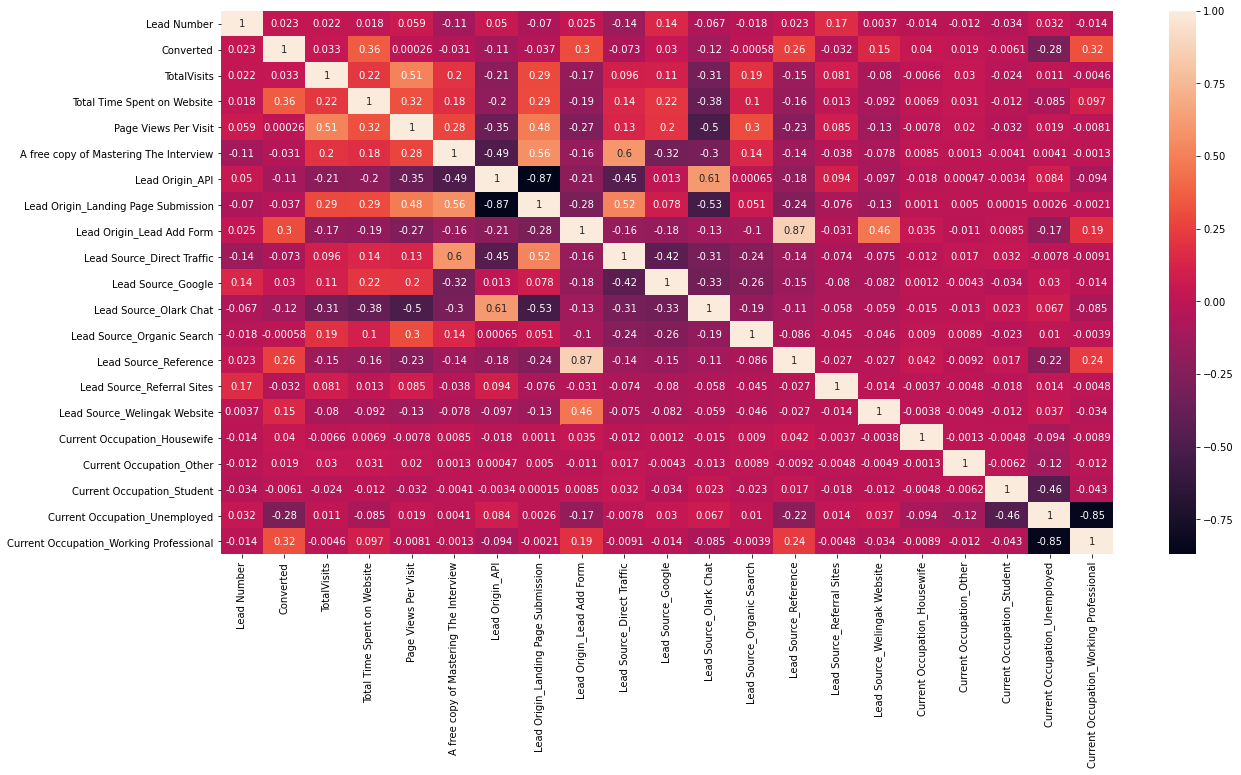

In [93]:
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(leads.corr(),annot = True)
plt.show()

# Running Your First Training Model

In [94]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6331
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3027.9
Date:                Wed, 09 Feb 2022   Deviance:                       6055.7
Time:                        17:13:52   Pearson chi2:                 6.59e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       1.4970      1.151      1.301      0.193      -0.758       3.752
TotalVisits                                 0.1319      0.049      2.719      0.007       0.037       0.227
Total Time Spent on Website                 1.1397      0.038     30.181      0.000       1.066       1.214
Page Views Per Visit                        0.0153      0.047      0.328      0.743      -0.076       0.107
A free copy of Mastering The Interview      0.0964      0.098      0.989      0.323      -0.095       0.288
Lead Origin_API                            -1.8935      0.759     -2.496      0.013      -3.380      -0.407
Lead Origin_Landing Page Submission        -1.9516      0.757     -2.578      0.010      -3.436      -0.468
Lead Origin_Lead Add Form                   1.0059      1.014      0.992      0.321      -0.982       2.994
Lead Source_Direct Traffic                  0.0989      0.612      0.162      0.872      -1.100       1.298
Lead Source_Google                          0.5587      0.608      0.918      0.358      -0.634       1.751
Lead Source_Olark Chat                      1.3347      0.618      2.161      0.031       0.124       2.545
Lead Source_Organic Search                  0.2732      0.614      0.445      0.656      -0.930       1.476
Lead Source_Reference                       1.6622      0.936      1.776      0.076      -0.172       3.496
Lead Source_Referral Sites                 -0.2992      0.688     -0.435      0.664      -1.647       1.049
Lead Source_Welingak Website                3.5660      1.158      3.080      0.002       1.296       5.835
Current Occupation_Housewife               21.6453   1.53e+04      0.001      0.999      -3e+04       3e+04
Current Occupation_Other                   -0.5841      1.281     -0.456      0.648      -3.095       1.927
Current Occupation_Student                 -0.8793      1.079     -0.815      0.415      -2.994       1.235
Current Occupation_Unemployed              -1.1152      1.060     -1.052      0.293      -3.193       0.963
Current Occupation_Working Professional     1.7157      1.074      1.598      0.110      -0.389       3.820
===========================================================================================================
"""

## Feature Selection Using RFE

In [95]:
logreg = LogisticRegression()

In [96]:
rfe = RFE(logreg, 15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

In [97]:
rfe.support_

array([False,  True, False, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [98]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('TotalVisits', False, 2),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', False, 5),
 ('A free copy of Mastering The Interview', False, 3),
 ('Lead Origin_API', True, 1),
 ('Lead Origin_Landing Page Submission', True, 1),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Source_Direct Traffic', True, 1),
 ('Lead Source_Google', False, 4),
 ('Lead Source_Olark Chat', True, 1),
 ('Lead Source_Organic Search', True, 1),
 ('Lead Source_Reference', True, 1),
 ('Lead Source_Referral Sites', True, 1),
 ('Lead Source_Welingak Website', True, 1),
 ('Current Occupation_Housewife', True, 1),
 ('Current Occupation_Other', True, 1),
 ('Current Occupation_Student', True, 1),
 ('Current Occupation_Unemployed', True, 1),
 ('Current Occupation_Working Professional', True, 1)]

In [99]:
col = X_train.columns[rfe.support_]

In [100]:
X_train.columns[~rfe.support_]

Index(['TotalVisits', 'Page Views Per Visit',
       'A free copy of Mastering The Interview', 'Lead Source_Google'],
      dtype='object')

## Assessing the model wth Stats

In [101]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6335
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3036.2
Date:                Wed, 09 Feb 2022   Deviance:                       6072.4
Time:                        17:13:53   Pearson chi2:                 6.60e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       1.4667      1.165      1.259      0.208      -0.816       3.750
Total Time Spent on Website                 1.1437      0.038     30.373      0.000       1.070       1.217
Lead Origin_API                            -1.2579      0.454     -2.770      0.006      -2.148      -0.368
Lead Origin_Landing Page Submission        -1.2464      0.452     -2.755      0.006      -2.133      -0.360
Lead Origin_Lead Add Form                   1.0873      0.998      1.089      0.276      -0.870       3.044
Lead Source_Direct Traffic                 -0.4175      0.087     -4.773      0.000      -0.589      -0.246
Lead Source_Olark Chat                      0.7011      0.112      6.246      0.000       0.481       0.921
Lead Source_Organic Search                 -0.1911      0.103     -1.853      0.064      -0.393       0.011
Lead Source_Reference                       1.5707      0.919      1.709      0.087      -0.230       3.371
Lead Source_Referral Sites                 -0.7233      0.324     -2.232      0.026      -1.358      -0.088
Lead Source_Welingak Website                3.4730      1.144      3.035      0.002       1.230       5.716
Current Occupation_Housewife               21.5343   1.54e+04      0.001      0.999   -3.01e+04    3.02e+04
Current Occupation_Other                   -0.5700      1.290     -0.442      0.659      -3.099       1.959
Current Occupation_Student                 -0.9576      1.094     -0.875      0.381      -3.102       1.186
Current Occupation_Unemployed              -1.1747      1.076     -1.092      0.275      -3.283       0.933
Current Occupation_Working Professional     1.6504      1.089      1.516      0.130      -0.484       3.785
===========================================================================================================
"""

In [102]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

3009    0.174357
1012    0.697563
9226    0.217365
4750    0.624243
7987    0.718221
1281    0.523514
2880    0.123225
4971    0.770566
7536    0.853509
1248    0.679854
dtype: float64

In [103]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.1743566 , 0.69756344, 0.21736492, 0.62424255, 0.71822092,
       0.52351372, 0.12322524, 0.77056648, 0.85350933, 0.67985367])

## Creating a dataframe with the actual Converted flag and the predicted probabilities

In [104]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values, 'Converted_Prob':y_train_pred})
y_train_pred_final['Prospect ID'] = y_train.index
y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID
0,0,0.174357,3009
1,0,0.697563,1012
2,0,0.217365,9226
3,1,0.624243,4750
4,1,0.718221,7987


In [105]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID,predicted
0,0,0.174357,3009,0
1,0,0.697563,1012,1
2,0,0.217365,9226,0
3,1,0.624243,4750,1
4,1,0.718221,7987,1


In [106]:
from sklearn import metrics

In [107]:
# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
print(confusion)

[[3429  476]
 [ 916 1530]]


In [108]:
y_train_pred_final['predicted'].value_counts()

0    4345
1    2006
Name: predicted, dtype: int64

In [109]:
y_train_pred_final['Converted'].value_counts()

0    3905
1    2446
Name: Converted, dtype: int64

In [110]:
# Predicted     not_converted    converted
# Actual
# not_converted        3429      476
# converted            916       1530

In [111]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.7808219178082192


In [112]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [113]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.6255110384300899

In [114]:
# Let us calculate specificity
TN / float(TN+FP)

0.8781049935979514

## Checking VIFs

In [115]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
13,Current Occupation_Unemployed,191.16
2,Lead Origin_Landing Page Submission,116.89
1,Lead Origin_API,85.51
3,Lead Origin_Lead Add Form,76.95
7,Lead Source_Reference,48.07
14,Current Occupation_Working Professional,17.05
9,Lead Source_Welingak Website,15.46
12,Current Occupation_Student,5.74
5,Lead Source_Olark Chat,2.39
4,Lead Source_Direct Traffic,2.15


In [116]:
# Dropping the variable 'Current Occupation_Unemployed' as it has large VIF

col = col.drop('Current Occupation_Unemployed', 1)
col

Index(['Total Time Spent on Website', 'Lead Origin_API',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Add Form',
       'Lead Source_Direct Traffic', 'Lead Source_Olark Chat',
       'Lead Source_Organic Search', 'Lead Source_Reference',
       'Lead Source_Referral Sites', 'Lead Source_Welingak Website',
       'Current Occupation_Housewife', 'Current Occupation_Other',
       'Current Occupation_Student',
       'Current Occupation_Working Professional'],
      dtype='object')

In [117]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6336
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3036.8
Date:                Wed, 09 Feb 2022   Deviance:                       6073.6
Time:                        17:13:53   Pearson chi2:                 6.60e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.2921      0.447      0.654      0.513      -0.583       1.167
Total Time Spent on Website                 1.1436      0.038     30.382      0.000       1.070       1.217
Lead Origin_API                            -1.2555      0.454     -2.765      0.006      -2.146      -0.365
Lead Origin_Landing Page Submission        -1.2469      0.452     -2.756      0.006      -2.134      -0.360
Lead Origin_Lead Add Form                   1.0877      0.998      1.089      0.276      -0.869       3.045
Lead Source_Direct Traffic                 -0.4159      0.087     -4.756      0.000      -0.587      -0.245
Lead Source_Olark Chat                      0.6987      0.112      6.227      0.000       0.479       0.919
Lead Source_Organic Search                 -0.1881      0.103     -1.825      0.068      -0.390       0.014
Lead Source_Reference                       1.5742      0.919      1.713      0.087      -0.227       3.375
Lead Source_Referral Sites                 -0.7249      0.324     -2.237      0.025      -1.360      -0.090
Lead Source_Welingak Website                3.4727      1.144      3.035      0.002       1.230       5.715
Current Occupation_Housewife               22.7065   1.54e+04      0.001      0.999   -3.01e+04    3.02e+04
Current Occupation_Other                    0.6025      0.715      0.843      0.399      -0.799       2.004
Current Occupation_Student                  0.2161      0.204      1.058      0.290      -0.184       0.616
Current Occupation_Working Professional     2.8240      0.177     15.923      0.000       2.476       3.172
===========================================================================================================
"""

In [118]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [119]:
y_train_pred[:10]

array([0.17450357, 0.6975378 , 0.21737554, 0.62447312, 0.71841826,
       0.52337472, 0.12316909, 0.77098349, 0.85362935, 0.68006663])

In [120]:
y_train_pred_final['Converted_Prob'] = y_train_pred

In [121]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID,predicted
0,0,0.174504,3009,0
1,0,0.697538,1012,1
2,0,0.217376,9226,0
3,1,0.624473,4750,1
4,1,0.718418,7987,1


In [122]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.7809793733270352


Checking VIFs again

In [123]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,Lead Origin_Lead Add Form,62.35
7,Lead Source_Reference,48.07
9,Lead Source_Welingak Website,15.46
2,Lead Origin_Landing Page Submission,2.47
1,Lead Origin_API,2.40
5,Lead Source_Olark Chat,2.39
4,Lead Source_Direct Traffic,2.15
6,Lead Source_Organic Search,1.40
0,Total Time Spent on Website,1.28
13,Current Occupation_Working Professional,1.18


In [124]:
# Dropping the variable'Lead Origin_Lead Add Form' as it has large VIF
col = col.drop('Lead Origin_Lead Add Form')
col

Index(['Total Time Spent on Website', 'Lead Origin_API',
       'Lead Origin_Landing Page Submission', 'Lead Source_Direct Traffic',
       'Lead Source_Olark Chat', 'Lead Source_Organic Search',
       'Lead Source_Reference', 'Lead Source_Referral Sites',
       'Lead Source_Welingak Website', 'Current Occupation_Housewife',
       'Current Occupation_Other', 'Current Occupation_Student',
       'Current Occupation_Working Professional'],
      dtype='object')

In [125]:
# Let's re-run the model using the selected variables
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6351
Model:                            GLM   Df Residuals:                     6337
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3037.4
Date:                Wed, 09 Feb 2022   Deviance:                       6074.9
Time:                        17:13:54   Pearson chi2:                 6.60e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                       0.5158      0.387      1.332      0.183      -0.243       1.275
Total Time Spent on Website                 1.1443      0.038     30.405      0.000       1.071       1.218
Lead Origin_API                            -1.4806      0.395     -3.746      0.000      -2.255      -0.706
Lead Origin_Landing Page Submission        -1.4711      0.394     -3.735      0.000      -2.243      -0.699
Lead Source_Direct Traffic                 -0.4157      0.087     -4.753      0.000      -0.587      -0.244
Lead Source_Olark Chat                      0.7017      0.112      6.257      0.000       0.482       0.921
Lead Source_Organic Search                 -0.1875      0.103     -1.819      0.069      -0.389       0.015
Lead Source_Reference                       2.4387      0.441      5.528      0.000       1.574       3.303
Lead Source_Referral Sites                 -0.7239      0.324     -2.234      0.025      -1.359      -0.089
Lead Source_Welingak Website                4.3372      0.812      5.340      0.000       2.745       5.929
Current Occupation_Housewife               22.7067   1.54e+04      0.001      0.999   -3.01e+04    3.02e+04
Current Occupation_Other                    0.6024      0.715      0.842      0.400      -0.799       2.004
Current Occupation_Student                  0.2159      0.204      1.057      0.290      -0.184       0.616
Current Occupation_Working Professional     2.8229      0.177     15.915      0.000       2.475       3.171
===========================================================================================================
"""

In [126]:
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [127]:
y_train_pred[:10]

array([0.17445836, 0.69720071, 0.21754657, 0.62466809, 0.7186345 ,
       0.52341453, 0.12306305, 0.77094839, 0.8538202 , 0.68027717])

In [128]:
y_train_pred_final['Converted_Prob'] = y_train_pred

In [129]:
# Creating new column 'predicted' with 1 if Churn_Prob > 0.5 else 0
y_train_pred_final['predicted'] = y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID,predicted
0,0,0.174458,3009,0
1,0,0.697201,1012,1
2,0,0.217547,9226,0
3,1,0.624668,4750,1
4,1,0.718635,7987,1


In [130]:
# Let's check the overall accuracy.
print(metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted))

0.7806644622894032


Checking VIFs again

In [131]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,Lead Origin_Landing Page Submission,2.47
1,Lead Origin_API,2.40
4,Lead Source_Olark Chat,2.38
3,Lead Source_Direct Traffic,2.15
5,Lead Source_Organic Search,1.40
0,Total Time Spent on Website,1.28
12,Current Occupation_Working Professional,1.18
6,Lead Source_Reference,1.16
7,Lead Source_Referral Sites,1.06
11,Current Occupation_Student,1.03


All variables have a good value of VIF. So we need not drop any more variables and we can proceed with making predictions using this model only

In [132]:
# Let's take a look at the confusion matrix again 
confusion = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.predicted )
confusion

array([[3431,  474],
       [ 919, 1527]], dtype=int64)

In [133]:
# Predicted     not_converted    converted
# Actual
# not_converted        3431      474
# converted            919       1527

In [134]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.predicted)

0.7806644622894032

In [135]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [136]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.6242845461978741

In [137]:
# Let us calculate specificity
TN / float(TN+FP)

0.8786171574903969

## Finding Optimal Cutoff Point

In [138]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Converted_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.174458,3009,0,1,1,0,0,0,0,0,0,0,0
1,0,0.697201,1012,1,1,1,1,1,1,1,1,0,0,0
2,0,0.217547,9226,0,1,1,1,0,0,0,0,0,0,0
3,1,0.624668,4750,1,1,1,1,1,1,1,1,0,0,0
4,1,0.718635,7987,1,1,1,1,1,1,1,1,1,0,0


In [139]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.385136  1.000000  0.000000
0.1   0.1  0.420879  0.988962  0.065045
0.2   0.2  0.641631  0.896975  0.481690
0.3   0.3  0.789325  0.755519  0.810499
0.4   0.4  0.794521  0.706051  0.849936
0.5   0.5  0.780664  0.624285  0.878617
0.6   0.6  0.764132  0.534751  0.907810
0.7   0.7  0.745080  0.425184  0.945455
0.8   0.8  0.724453  0.326247  0.973880
0.9   0.9  0.684774  0.188880  0.995391


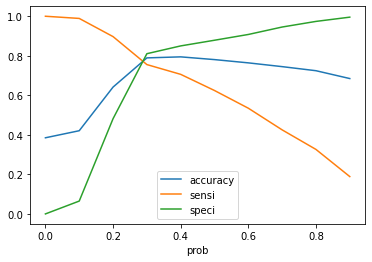

In [140]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

In [141]:
## From the curve above, 0.3 is the optimum point to take it as a cutoff probability

In [142]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Converted_Prob.map( lambda x: 1 if x > 0.3 else 0)

y_train_pred_final.head()

,Converted,Converted_Prob,Prospect ID,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.174458,3009,0,1,1,0,0,0,0,0,0,0,0,0
1,0,0.697201,1012,1,1,1,1,1,1,1,1,0,0,0,1
2,0,0.217547,9226,0,1,1,1,0,0,0,0,0,0,0,0
3,1,0.624668,4750,1,1,1,1,1,1,1,1,0,0,0,1
4,1,0.718635,7987,1,1,1,1,1,1,1,1,1,0,0,1


In [143]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_train_pred_final.Converted, y_train_pred_final.final_predicted)

0.7893245158242796

In [144]:
confusion2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted )
confusion2

array([[3165,  740],
       [ 598, 1848]], dtype=int64)

In [145]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [146]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7555192150449714

## Correlation to find the top 3 variables

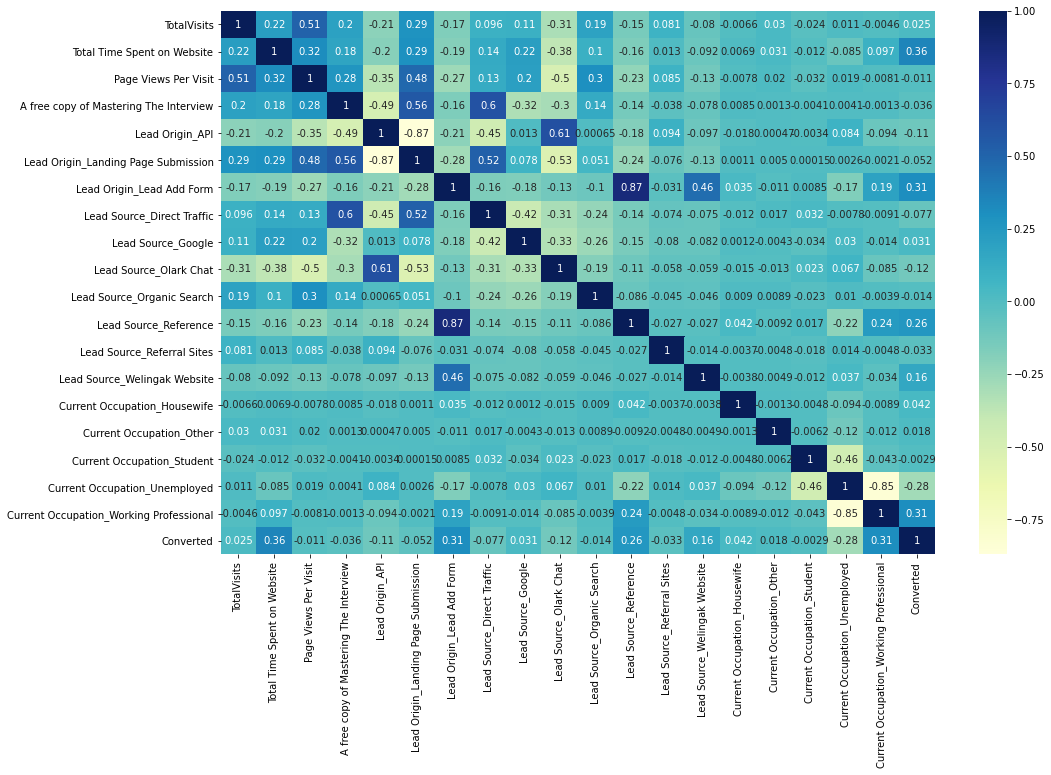

In [147]:
final_df = pd.concat([X,y_train], axis=1)
plt.figure(figsize = (16, 10))
sns.heatmap(final_df.corr(), annot = True, cmap="YlGnBu")
plt.show()

Below are the top 3 Variables that can contribute most towards the successful Lead convesrion 
1.Total time spent on Website
2.Current Occupation_Working Professional
3.Lead Source_Reference

## Making predictions on the test set

In [148]:
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])


In [149]:
X_test = X_test[col]
X_test.head()

,Total Time Spent on Website,Lead Origin_API,Lead Origin_Landing Page Submission,Lead Source_Direct Traffic,Lead Source_Olark Chat,Lead Source_Organic Search,Lead Source_Reference,Lead Source_Referral Sites,Lead Source_Welingak Website,Current Occupation_Housewife,Current Occupation_Other,Current Occupation_Student,Current Occupation_Working Professional
3271,-0.600595,1,0,0,0,0,0,0,0,0,0,0,0
1490,1.887326,0,1,1,0,0,0,0,0,0,0,0,1
7936,-0.752879,1,0,0,0,0,0,0,0,0,0,0,0
4216,-0.888650,0,0,0,0,0,1,0,0,0,0,1,0
3830,-0.587751,0,1,0,0,1,0,0,0,0,0,0,0


In [150]:
X_test_sm = sm.add_constant(X_test)

In [151]:
y_test_pred = res.predict(X_test_sm)

In [152]:
y_test_pred[:10]

3271    0.160828
1490    0.973701
7936    0.138675
4216    0.896004
3830    0.140001
1800    0.733092
6507    0.154295
4821    0.277678
4223    0.874094
4714    0.217547
dtype: float64

In [153]:
# Converting y_pred to a dataframe which is an array
y_pred_1 = pd.DataFrame(y_test_pred)

In [154]:
y_pred_1.head()

,0
3271,0.160828
1490,0.973701
7936,0.138675
4216,0.896004
3830,0.140001


In [155]:
# Converting y_test to dataframe
y_test_df = pd.DataFrame(y_test)

In [156]:
# Putting Prospect ID to index
y_test_df['Prospect ID'] = y_test_df.index

In [157]:
# Removing index for both dataframes to append them side by side 
y_pred_1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [158]:
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_test_df, y_pred_1],axis=1)

In [159]:
y_pred_final.head()

,Converted,Prospect ID,0
0,0,3271,0.160828
1,1,1490,0.973701
2,0,7936,0.138675
3,1,4216,0.896004
4,0,3830,0.140001


In [160]:
# Renaming the column 
y_pred_final= y_pred_final.rename(columns={ 0 : 'Converted_Prob'})

In [161]:
y_pred_final.head()

,Converted,Prospect ID,Converted_Prob
0,0,3271,0.160828
1,1,1490,0.973701
2,0,7936,0.138675
3,1,4216,0.896004
4,0,3830,0.140001


In [162]:
y_pred_final['final_predicted'] = y_pred_final.Converted_Prob.map(lambda x: 1 if x > 0.3 else 0)

In [163]:
y_pred_final.head()

,Converted,Prospect ID,Converted_Prob,final_predicted
0,0,3271,0.160828,0
1,1,1490,0.973701,1
2,0,7936,0.138675,0
3,1,4216,0.896004,1
4,0,3830,0.140001,0


In [164]:
# Let's check the overall accuracy.
metrics.accuracy_score(y_pred_final.Converted, y_pred_final.final_predicted)

0.795813441057657

In [165]:
confusion2 = metrics.confusion_matrix(y_pred_final.Converted, y_pred_final.final_predicted )
confusion2

array([[1429,  305],
       [ 251,  738]], dtype=int64)

In [166]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [167]:
# Let's see the sensitivity of our logistic regression model
TP / float(TP+FN)

0.7462082912032356

In [168]:
y_pred_final['Lead Score'] = round(y_pred_final['Converted_Prob']*100, 2)

In [169]:
y_pred_final.head()

,Converted,Prospect ID,Converted_Prob,final_predicted,Lead Score
0,0,3271,0.160828,0,16.08
1,1,1490,0.973701,1,97.37
2,0,7936,0.138675,0,13.87
3,1,4216,0.896004,1,89.60
4,0,3830,0.140001,0,14.00
